In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import os
from PIL import Image
from datetime import datetime

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


In [4]:
data_dir = 'data/flowers_/'

In [5]:
train_dataset = datasets.ImageFolder(data_dir+'/train', train_transform)
test_dataset = datasets.ImageFolder(data_dir+'/test', test_transform)
print(len(train_dataset))
print(len(test_dataset))

3027
1296


In [6]:
## ovo gore je laganica. Mi hoćemo svoj dataset objekt
class DataSet(torch.utils.data.Dataset):
    def __init__(self, datatype, datadir, transform):
        super().__init__()
        datadir = datadir + datatype +'/'
        self.transform = transform
        self.paths = []
        self.labels = []
        self.class_names = []
        
        for i, dir in enumerate(os.listdir(datadir)):
            self.class_names.append(dir)
            for file in os.listdir(datadir+dir):
                self.paths.append(datadir+dir+'/'+file)
                self.labels.append(i)
    def __getitem__(self,idx):
        img = Image.open(self.paths[idx])
        img_tensor = self.transform(img) # u ovom trenutku img objekt postaje pytorch tensor
        label_tensor = torch.FloatTensor([self.labels[idx]])
        return img_tensor, label_tensor
    
    def __len__(self):
        return len(self.paths)

In [7]:
test_dataset =  DataSet('test', data_dir, test_transform)
train_dataset = DataSet('train', data_dir, train_transform)


In [8]:
print(len(test_dataset))
print(len(train_dataset))

1296
3027


In [9]:
train_loader = data.DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 1)
test_loader = data.DataLoader(test_dataset, batch_size = 8, shuffle = False, num_workers = 1)


In [10]:
import numpy as np
from matplotlib import pyplot as plt

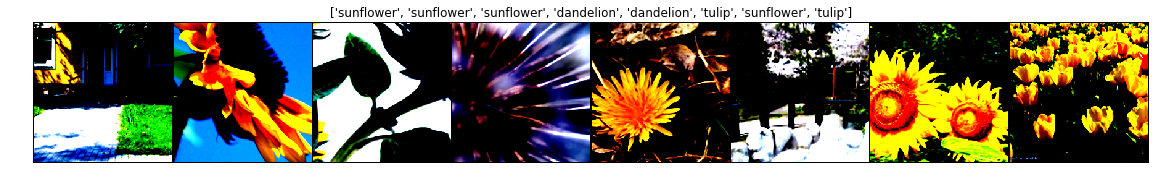

In [11]:
def visualise_batch(loader,dataset):
    inputs , labels = next(iter(loader))
    inp = torchvision.utils.make_grid(inputs)
    inp = np.clip(inp,0,1)
    inp = inp.numpy().transpose((1,2,0))
    plt.figure(figsize =(20,6))
    plt.axis('off')
    plt.title([dataset.class_names[int(i)] for i in labels])
    plt.imshow(inp)

visualise_batch(train_loader, train_dataset)

In [12]:
model = models.alexnet(pretrained = True)

In [13]:
import torch.nn as nn
class MyNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        #Freeze alexmodel
        for param in self.model.parameters():
            param.requires_grad = False
            
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 5)
    def forward(self, x):
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [14]:
use_gpu = True
model = MyNet()
if use_gpu:
    model = model.cuda()

In [15]:
def run_model(model, loader, loss_fn, train = False, optimizer = None, use_gpu = False):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.
    num_batches = 0
    corr_pred = 0
    
    for idx, batch in enumerate(loader):
        if train:
            optimizer.zero_grad()
        batch_data, labels = batch
        labels = torch.reshape(labels, [-1])
        labels = labels.long()
        
        if use_gpu:
            batch_data= batch_data.cuda()
            
        outputs = model.forward(batch_data)
        
        if use_gpu:
            outputs = outputs.cuda()
            labels = labels.cuda()
            
        loss = loss_fn(outputs, labels)
        
        outputs = outputs.cpu()
        labels = labels.cpu
        _, predictions = torch.max(outputs, 1)
        corr_pred += torch.sum(predictions == labels)
        total_loss += loss.item()
        
        if train:
            loss.backward()
            optimizer.step()
        
        num_batches +=1
    avg_loss = total_los / num_batches
    precision = corr_pred.item() / len(loader_dataset)
    return avg_loss, precision

In [16]:
def train(model, epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

    start_time =  datetime.now()

    for epoch in range(epochs):
        change =  datetime.now() - start_time
        print("Starting epoch {}. time passed: {}".format(epoch+1, str(change)))

        train_loss, train_precision = run_model(model, train_loader, loss_fn,True, optimizer)

        print('train loss: {0:.4f}'.format(train_loss))
        print('train precision: {0:.4f}'.format(train_precision))

        scheduler.step()

In [ ]:
train(model,1)

Starting epoch 1. time passed: 0:00:00.000004


In [17]:
run_model(model, test_loader,nn.CrossEntropyLoss(), train= False, optimizer = None)

NameError: name 'total_los' is not defined